0.0437153697719919


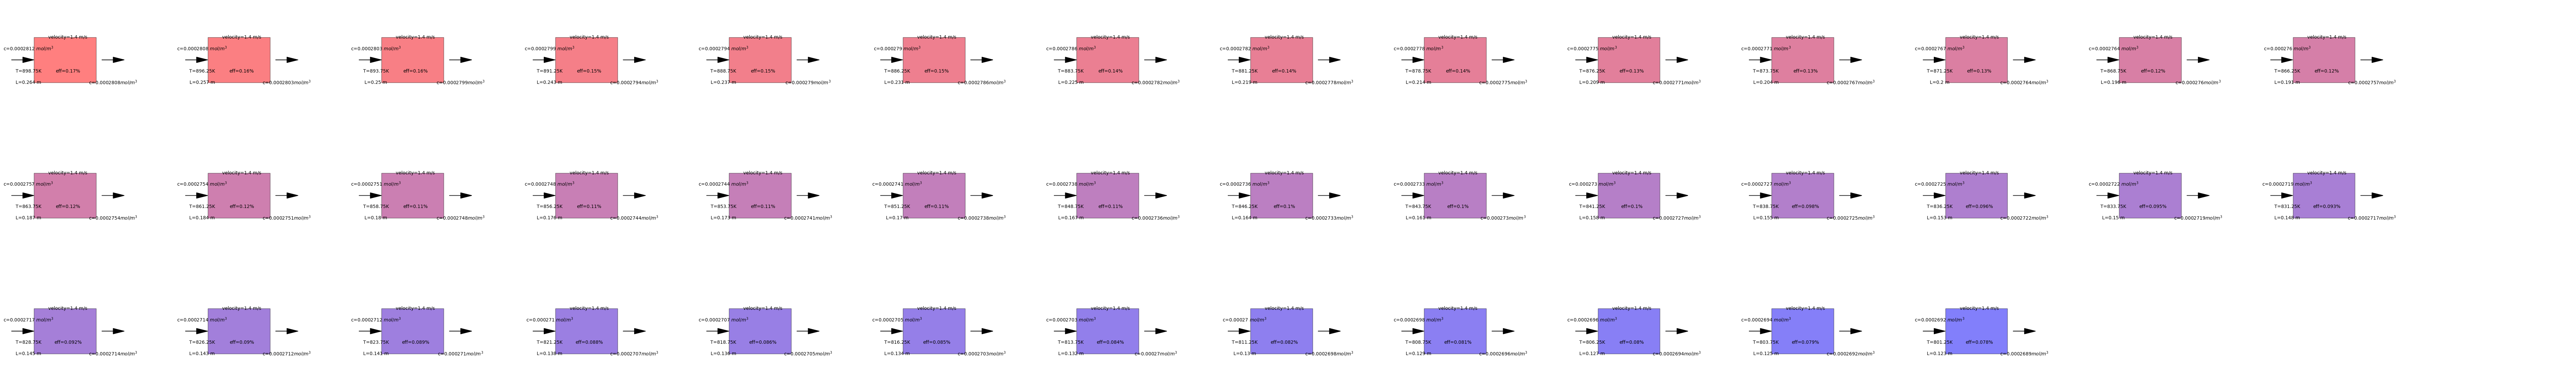

In [1]:

import sys
import os
sys.path.append(os.path.abspath('..'))
from scipy.constants import N_A
from scipy.constants import physical_constants
import numpy as np 
from tools.component_tools import Component
from tools.component_tools import Fluid
from tools.component_tools import Membrane , Geometry 
from tools.materials import Flibe 
import tools.correlations as corr
import tools.materials as materials
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from scipy.optimize import fsolve
import matplotlib.lines as mlines
from tools.component_tools import BreedingBlanket
from scipy.constants import R

T=973.15
L=10
d_hyd=25.4E-3

mat=materials.Flibe(T)

rho_flibe=2415.6-0.49072*T
n_pipes=2000
n_pipes_HX=3000
mu_flibe=1.16E-4*np.exp(3755/T)
k_H=8.27E-9*np.exp(4.27E-3*T)
D_flibe=9.3E-7*np.exp((-42E3)/(R*T))
K_S_S=953*np.exp((-10.7E3)/(R*T))*1E-3
D_S=7.43E-7*np.exp((-44.1E3)/(R*T))

flibe=Fluid(T=T, Solubility=k_H, MS=True,D=D_flibe, d_Hyd=d_hyd ,mu=mu_flibe,rho=rho_flibe,U0=1,k=mat.k,
    cp=mat.cp)
BB=BreedingBlanket(Q=0.625E9,TBR=1.08,T_in=800,T_out=900,c_in=0, fluid=flibe)
BB.get_flowrate()
BB.get_cout()
c0=BB.c_out
U0=BB.m_coolant/(rho_flibe*np.pi*d_hyd**2/4*n_pipes)
err=1
tol=1E-6
c_in=c0
i=0
geometry=Geometry(D=d_hyd,L=L,thick=0.25E-3)
flibe=Fluid(T=T, Solubility=k_H, MS=True,D=D_flibe, d_Hyd=d_hyd ,mu=mu_flibe,rho=rho_flibe,U0=U0,k=mat.k,
    cp=mat.cp)
Steel = Membrane( T=T,
        D=D_S,
        thick=0.25E-3,
        K_S=K_S_S,
        k_d=1E6,
        k_r=1E6,k=21)
mat_HX=materials.Flibe((BB.T_in+BB.T_out)/2)
d_hyd_HX=20E-3
U0_HX=BB.m_coolant/(mat_HX.rho*np.pi*d_hyd_HX**2/4*n_pipes_HX)
flibe_HX=Fluid(T=(BB.T_in+BB.T_out)/2, Solubility=mat_HX.Solubility, MS=True,D=mat_HX.D, d_Hyd=d_hyd_HX ,mu=mat_HX.mu,U0=U0_HX,rho=mat_HX.rho,k=mat.k,cp=mat_HX.cp)
geometry_HX=Geometry(D=d_hyd_HX,L=L,thick=0.25E-3)
HX = Component(c_in=c_in,geometry=geometry_HX, fluid=flibe_HX, membrane=Steel)
PAV_geometry=Geometry(D=d_hyd,L=L,thick=0.25E-3)
PAV = Component(c_in=c_in,geometry=PAV_geometry, fluid=flibe, membrane=Steel) 
HX.get_global_HX_coeff(0)
circuit_HX=HX.split_HX(N=41,T_in_hot=BB.T_out,T_out_hot=BB.T_in,T_in_cold=581,T_out_cold=800,U=HX.U,Q=BB.Q/n_pipes_HX)

circuit_HX.solve_circuit()
circuit_HX.get_eff_circuit()
print(circuit_HX.eff)
circuit_HX.plot_circuit()